Bank Attrition Rates - SDC Analysis Vignette
============================================

### Scenario 
A Bank manager is concerened with customer attrition rates. They collected data on the 
their customers which they would like publically release in order to crowd-source an 
attrition model. The attrition model must have a prediction accuracy greater than 90%.
For disclosure purposes, the Bank's HR department informs the Manager that their 
customer's `Marital Status` cannot be released. Prior to releasing the data, 
the Manager must remove information regarding their client's Martial Status as well as 
any lingering relationships that may identify their `Marital Status`.

### Notebook Details

This notebook will cover Steps 5-7 outlined in the Vignette Template `README.md`. Steps
1-4 and 8 are outlined in `data-analysis.ipynb`.

The goal of this notebook is to exemplify a scenario where a user must mitigate, or
minimize, attribute disclosure risk in a dataset through the use of SDC techniques.

This requires a user to identify the key features and/or relationships of a dataset 
to mitigate, as well as the SDC methods that will apply the mitigations, and evaluate
their effect on attribute disclosure risk.

This is usually a manual, trial-and-error process, which can be automated with `pymasq`,
as will be shown in this notebook.

Note that while only attribute disclosure risk is evaluated in this notebook, it is
recommended to also evaluate information loss to ensure the utility of the data is 
maintained, thereby ensuring positive results in `data-analysis.ipynb`.

These steps are only meant to be demonstrative on how to effectively use `pymasq`. Thus,
some implementation choices, like mitigation selection and their parameters, are only
meant to be a guide and are not configured for optimal performance. Nonethelesss, the
steps presented should be applicable to a variety of scenarios, datasets, mdoels, etc.


In [1]:
import warnings
warnings.filterwarnings('ignore')

from pymasq.datasets import load_bank_attrition_rates
from pymasq import kve
from pymasq import mitigations as mits
from pymasq import metrics as mets
from pymasq import optimizations as opts

import matplotlib.pyplot as plt
import numpy as np
import random
import yaml

np.random.seed(1)
random.seed(1)

In [2]:
MS = "Marital_Status"
AF = "Attrition_Flag"
orig_df = load_bank_attrition_rates()
AF_df = orig_df.pop(AF) # don't include AF in SDC calculations; re-append it at end
mod_df = orig_df.copy()
print(orig_df.shape)
orig_df.head()

(10127, 19)


,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,45,1,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,49,0,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,51,1,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,40,0,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,40,1,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


### Step 5

_Perform initial Risk and/or Utility evaluations to be used as a baseline._
 
In this scenario, we are attempting to mitigate attritbute disclosure risk for the 
`Marital Status` variable. We will use `pymasq.metrics.auc_score` to evaluate attribute 
disclosure risk.

The `pymasq.metrics.auc_score` metric will train a classifier (in this case, a Random
Forest classifier) to predict the `Marital Status` of the dataset.

Attribute disclosure risk is calculated as the ratio in classification performance with 
respect to the original dataset and the current, mitigated dataset. 

Naturally, the intial risk assessment will be 1.0, or 100%, in all cases, since the 
dataset has not yet been mitigated, and will serve as our baseline risk.

In [3]:
assert orig_df.equals(mod_df), "DataFrames not equal; re-run notebook from the beginning"
mets.auc_score(orig_df, mod_df, MS, method="rfclass")

1.0

### Step 6

_Perform Key Variable Exploration (KVE) with `pymasq` to identify features with highest correlation to SV. Determine relevant features (columns) to be considered Key Variables (KVs)._

This step requires the user to identify the key variables and relationships they wish to
obsucre in an effort to mitigate, or minimize, attribute disclosure risk with respect to
the SV, `Marital Status`.

`KVE` can run several standard Machine Learning algorithms used for feature importance
ranking and provides an inclusion recommendation for each feature (i.e., a
recommendation as to wether or not a feature should be considered a KV).

Recommendations range from `No`, `Maybe`, and `Yes`. By default, a `Yes` indicates all
selected algorithms considered the feature important, and should therefore be 
considered a Key Variable. A `Maybe` states that at least 1 algorithm considered the
feature important (i.e., returned `Yes`). Lastly, a `No` indicates that no algorithm
considered the feature important.

Note that the recommendations returned by KVE are made from a purely algorithmic 
perspective with the given parameters/hyperparameters. The recommendations should be
disregarded or augmented with user insight (e.g., subject matter expert) or additional
data and relationships not captured in the dataset.

Furthermore, `KVE` is but a convenience method and is not strictly required to be used.

In [4]:
kve_scores = kve.key_variable_exploration(orig_df, sensitive_col=MS)
kve_scores["evidence"]

,Variable,Random_Forest,Random_Forest_Include,Boruta_Include,RFE_Include,Stepwise_Include,Include,Embedding
0,Total_Trans_Amt,0.0885,yes,yes,no,yes,maybe,NA
1,Total_Amt_Chng_Q4_Q1,0.0758,yes,yes,no,yes,maybe,NA
2,Total_Trans_Ct,0.0757,yes,yes,no,yes,maybe,NA
3,Customer_Age,0.0731,yes,yes,no,no,maybe,NA
4,Total_Ct_Chng_Q4_Q1,0.0702,no,maybe,no,no,maybe,NA
5,Avg_Open_To_Buy,0.0651,yes,no,no,no,maybe,NA
6,Months_on_book,0.0578,yes,no,no,no,maybe,NA
7,Total_Revolving_Bal,0.0530,no,no,no,yes,maybe,NA
8,Total_Relationship_Count,0.0354,yes,no,no,no,maybe,NA
9,Education_Level,0.0168,yes,no,no,no,maybe,Education_Level_2


### Step 7
_From here, you have the option to perform step 7 manually (7.m), automatically (7.a), or both._

The following features were selected as KVs given the results from `KVE` and user
insight:
1. Total_Amt_Chng_Q4_Q1
2. Total_Ct_Chng_Q4_Q1
3. Credit_Limit
4. Avg_Open_To_Buy
5. Total_Trans_Ct
6. Customer_Age
7. Dependent_count
8. Total_Relationship_Count
9. Total_Revolving_Bal
10. Total_Trans_Amt
11. Contacts_Count_12_mon
12. Months_Inactive_12_mon

It may be beneficial to mitigate features with high correlations with each other in 
concert. We consider the following features with high correlations in the dataset:
- Total_Amt_Chng_Q4_Q1, Total_Ct_Chng_Q4_Q1
- Credit_Limit, Avg_Open_To_Buy
- Dependent_count, Total_Relationship_Count
- Total_Revolving_Bal, Total_Trans_Amt
- Contacts_Count_12_mon, Months_Inactive_12_mon

Note that the KVs selected will guide the choice of SDC methods (i.e., mitigations) to 
apply and their respective parameters, which, in-turn, will the overall attribute
disclsoure risk. Thus, it is imperative to perform a thorough analysis of your dataset 
to achieve the best expected outcomes. 

The user should keep in mind that `pymasq` cannot guarantee the realistic 
properties and relationships of a dataset will be conserved while being mitigated. For 
example, a mitigation may create negative values for which those values may not be 
valid or make sense (i.e., negative value for age). These instances are not limited to
`pymasq` and can arise in any tool used for mitigating disclosure risk.

In [5]:
# Utility function to display value changes
def plot_hist(orig, mod):
    fig, axs = plt.subplots(1, len(orig), figsize=(8, 3))
    axs = [axs] if not isinstance(axs, np.ndarray) else axs        
    for idx, ax in enumerate(axs):
        ax.hist(orig[idx], label="orig", bins=20, alpha=0.6)
        ax.hist(mod[idx], label="mod", bins=20, alpha=0.6)
        ax.set_title(orig[idx].name)
        ax.legend()
    plt.show()

##### Step 7.m
_Manually mitigate KVs via trial and error._

Here, we manually select 7 mitigations and set their parameter values.

For brevity, we only evaluate attribute disclosure risk after we applied all 7 
mitigations. However, the choice of mitigations and their respective parameter values
were guided through trial-and-error calculations of attribute disclosure risk that is 
not shown in this notebook.

Note that, in general, it is recommended to evaluate a mitigation's impact on risk 
and/or utility imediately after being applied, though it is not necessary.

For additional context and ease of (visual) inspection, we plot an overlapping histogram
of each feature that was mitigated pre- and post-mitigation.

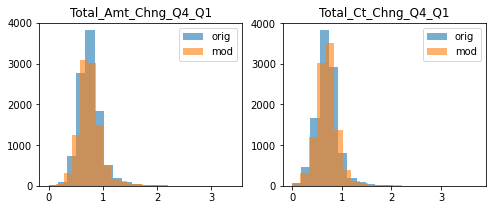

In [6]:
cols = ["Total_Amt_Chng_Q4_Q1", "Total_Ct_Chng_Q4_Q1"]
mod_df[cols] = mits.robust_magg(mod_df, aggr=3, cols=cols)
plot_hist(
    [orig_df[cols[0]], orig_df[cols[1]]],
    [mod_df[cols[0]], mod_df[cols[1]]]
)

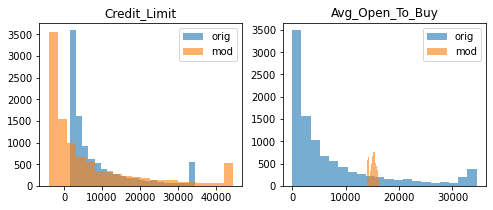

In [7]:
cols = ["Credit_Limit", "Avg_Open_To_Buy"]
mod_df[[MS]+cols] = mits.geom_transform(
    mod_df, 
    perturb_cols=cols, 
    sensitive_col=MS, 
    magnitude=0.05, 
    shuffle=False, 
    cols=[MS]+cols
)
plot_hist(
    [orig_df[cols[0]], orig_df[cols[1]]], 
    [mod_df[cols[0]], mod_df[cols[1]]]
)

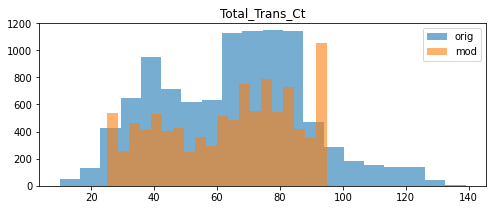

In [8]:
cols = ["Total_Trans_Ct"]
mod_df[cols] = mits.topbot_recoding(
    mod_df, method="both", top_cutoff=95, bot_cutoff=25, cols=cols
)
plot_hist(
    [orig_df[cols[0]]],
    [mod_df[cols[0]]]
)

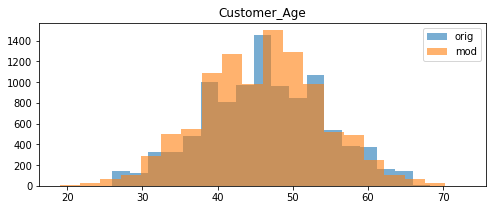

In [9]:
cols = ["Customer_Age"]        
mod_df[cols] = mits.add_noise_additive(
    mod_df, magnitude=50, centered=True, cols=cols, keep_dtypes=True
)
plot_hist(
    [orig_df[cols[0]]], 
    [mod_df[cols[0]]]
)

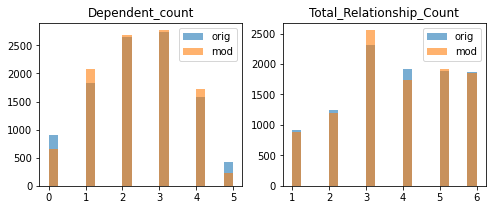

In [10]:
cols = ["Dependent_count", "Total_Relationship_Count"]    
mod_df[cols] = mits.advanced_magg(
    mod_df, aggr=3, measure="median", clust="kmeans", scale="standard", cols=cols
)
plot_hist(
    [orig_df[cols[0]], orig_df[cols[1]]], 
    [mod_df[cols[0]], mod_df[cols[1]]]    
)

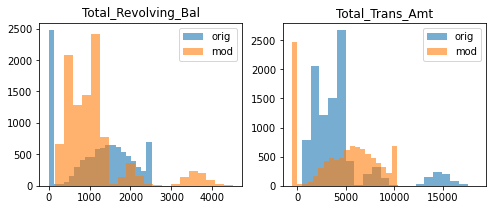

In [11]:
cols = ["Total_Revolving_Bal", "Total_Trans_Amt"] 
mod_df[[MS]+cols] = mits.geom_transform(
    mod_df, perturb_cols=cols,  sensitive_col=MS, magnitude=0.04, cols=[MS]+cols
)
plot_hist(
    [orig_df[cols[0]], orig_df[cols[1]]],
    [mod_df[cols[0]], mod_df[cols[1]]]
)

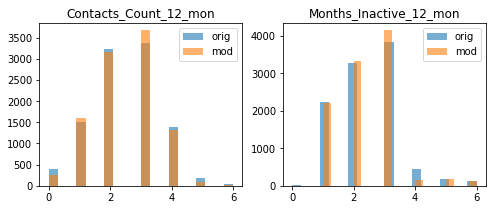

In [12]:
cols = ["Contacts_Count_12_mon", "Months_Inactive_12_mon"]
mod_df[cols] = mits.advanced_magg(
    mod_df,  aggr=3,  cols=cols,  measure="median", clust="kmeans", scale="standard"
)
plot_hist(
    [orig_df[cols[0]], orig_df[cols[1]]],
    [mod_df[cols[0]], mod_df[cols[1]]]
)

In [13]:
# re-calculate attribute disclosure risk with the current, mitigated dataset
# (lower is better)
mets.auc_score(orig_df, mod_df, MS, method="rfclass")

0.00700407018231007

##### Step 7.a
_Auatomically mitigate KVs via optimization or search procedure._

Here, we manually select  mitigations and with a variety of parameter values.

In contrast with Step 7.m - where mitigations were applied manually, with only a limited
number of parameter values, and risk was evaluated only at the end - Step 7.a, will use
the `pymasq.optimization.StochasticSearch` procedure to find an optimal mitigation
strategy (i.e., set of mitigations and their respective parameters which had the best
effect on mitigating attribute disclosure risk). 

In [14]:
# load the `opt-parameters.yaml`` with the configuration for each mitigation (mutation), 
# metric, and their respective parameter values. Please review `opt-parameters.yaml` 
# for more info.
yaml_fname = "opt-parameters.yaml"
with open(yaml_fname) as f:
    cfg = yaml.safe_load(f)

mits_list = cfg["mitigations"]
mets_dict = cfg["metrics"]

In [15]:
mits_list

[{'add_noise_additive': {'magnitude': 20,
   'centered': True,
   'keep_dtypes': True,
   'cols': 'Customer_Age'}},
 {'add_noise_additive': {'magnitude': 50,
   'centered': True,
   'keep_dtypes': True,
   'cols': 'Customer_Age'}},
 {'add_noise_additive': {'magnitude': 5,
   'centered': True,
   'keep_dtypes': True,
   'cols': 'Customer_Age'}},
 {'add_noise_restricted': {'magnitude': 50,
   'keep_dtypes': True,
   'cols': 'Customer_Age'}},
 {'robust_magg': {'aggr': 3,
   'keep_dtypes': True,
   'cols': ['Total_Amt_Chng_Q4_Q1', 'Total_Ct_Chng_Q4_Q1']}},
 {'robust_magg': {'aggr': 5,
   'keep_dtypes': True,
   'cols': ['Total_Amt_Chng_Q4_Q1', 'Total_Ct_Chng_Q4_Q1']}},
 {'robust_magg': {'aggr': 10,
   'keep_dtypes': True,
   'cols': ['Total_Amt_Chng_Q4_Q1', 'Total_Ct_Chng_Q4_Q1']}},
 {'robust_magg': {'aggr': 20,
   'keep_dtypes': True,
   'cols': ['Total_Amt_Chng_Q4_Q1', 'Total_Ct_Chng_Q4_Q1']}},
 {'robust_magg': {'aggr': 50,
   'keep_dtypes': True,
   'cols': ['Total_Amt_Chng_Q4_Q1', 'Tot

In [16]:
search = opts.StochasticSearch(
    orig_df, 
    iters=20,
    mutations=mits_list,            # mitigations from loaded config
    metrics=mets_dict,              # metrics from loaded config
    theta=0.0,                      # evaluation threshold to try and meet
    reuse_mutations=False,          # allow mitigations to be re-used
    randomize_mutations=True,       # apply mitigations in the random order
    alpha=0.25,                     # specify annealing rate 
    verbose=2
) 
opt_df, fitness, log = search.optimize()

[Starting ...]
	[Evaluation]: <function auc_score at 0x7f54212dd550>
-- Iteration [0] --
	[Mutation]: <function robust_magg at 0x7f53cb54b9d0> {'aggr': 50, 'keep_dtypes': True, 'cols': ['Total_Amt_Chng_Q4_Q1', 'Total_Ct_Chng_Q4_Q1']}
	[Evaluation]: <function auc_score at 0x7f54212dd550>
>> Current fitness: 1.00000 |  New fitness: 0.96369 |  Best fitness: 1.00000
>> New solution accepted 
>> New [best] solution found: 0.9636899383157544 < 1.0
-- Iteration [1] --
	[Mutation]: <function topbot_recoding at 0x7f53cb551a60> {'method': 'both', 'top_cutoff': 80, 'bot_cutoff': 40, 'cols': 'Total_Trans_Ct'}
	[Evaluation]: <function auc_score at 0x7f54212dd550>
>> Current fitness: 0.96369 |  New fitness: 0.90552 |  Best fitness: 0.96369
>> New solution accepted 
>> New [best] solution found: 0.9055207336344796 < 0.9636899383157544
-- Iteration [2] --
	[Mutation]: <function geom_transform at 0x7f53cb84ddc0> {'perturb_cols': ['Credit_Limit', 'Avg_Open_To_Buy'], 'sensitive_col': 'Marital_Status', 'm

>> Current fitness: 0.14238 |  New fitness: 0.13769 |  Best fitness: 0.14238
>> New solution accepted 
>> New [best] solution found: 0.13768738741801925 < 0.14238384973028803
>>> [Terminating]: Iterations complete
[... Search Complete]


In [17]:
# View the `log` to see which mitigations were applied at each iteration as well as 
# their impact on the selected evaluation metric, `auc_score`.
log

,fitness,mut_log,auc_score,accepted,error_log
0,1.0,{},"(1.0, 1.0)",True,[]
1,0.96369,"{'robust_magg': {'aggr': 50, 'keep_dtypes': Tr...","(0.9636899383157544, 1.0)",True,[]
2,0.905521,"{'topbot_recoding': {'method': 'both', 'top_cu...","(0.9055207336344796, 1.0)",True,[]
3,0.636789,{'geom_transform': {'perturb_cols': ['Credit_L...,"(0.6367888262960556, 1.0)",True,[]
4,0.614351,"{'advanced_magg': {'aggr': 3, 'measure': 'medi...","(0.6143511644801803, 1.0)",True,[]
5,0.57095,"{'add_noise_additive': {'magnitude': 20, 'cent...","(0.5709501901434489, 1.0)",True,[]
6,0.231695,{'geom_transform': {'perturb_cols': ['Total_Re...,"(0.23169451024543555, 1.0)",True,[]
7,0.229906,"{'add_noise_correlated': {'keep_dtypes': True,...","(0.22990620401178244, 1.0)",True,[]
8,0.212329,"{'add_noise_restricted': {'magnitude': 50, 'ke...","(0.21232879437373384, 1.0)",True,[]
9,0.212329,"{'topbot_recoding': {'method': 'both', 'top_cu...","(0.21232879437373384, 1.0)",False,[]


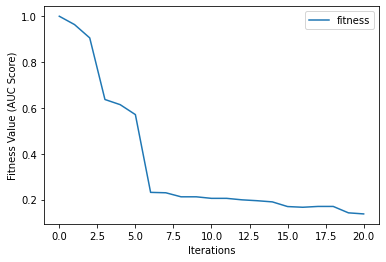

In [18]:
# plot the overall fitness; lower values indicate lower disclosure risk (AUC Score)
ax = log.plot(y="fitness")
ax.set_xlabel("Iterations")
ax.set_ylabel("Fitness Value (AUC Score)")
plt.show()

#### Step 8
_Perform regression or classification task on modified dataset, having removed the SV feature._

We will calculate the classification accuracy on the mitigated dataset in 
`data-analysis.ipynb` using the manually mitigated, `mod_df` and automatically 
mitigated `opt_df`.

In [19]:
# Save out `mod_df` and `opt_df` to be used in `data-analysis.ipynb`
mod_df[AF] = AF_df
opt_df[AF] = AF_df

f1 = "manual-mod-bank-attrition-rates.csv"
f2 = "auto-mod-bank-attrition-rates.csv"

mod_df.to_csv(f1)
opt_df.to_csv(f2)